In [1]:
%matplotlib inline
import tqdm
import numpy as np
import healpy as hp
from matplotlib import animation
import matplotlib.pyplot as plt
import glob

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 2000

In [2]:
files = sorted(glob.glob("cloud_cover/*.jpg"))

In [3]:
im = plt.imread(files[0], format='jpeg')

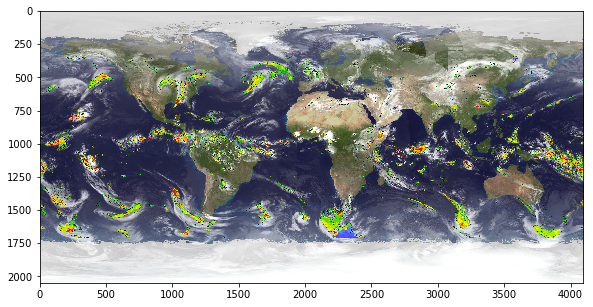

In [4]:
plt.figure(figsize=(10, 5))
plt.imshow(im)

In [5]:
nside = 64
x_size = im.shape[1]
y_size = im.shape[0]
channels = im.shape[2]

In [6]:
long, lat = np.meshgrid(np.linspace(-np.pi, np.pi, x_size), np.linspace(0, np.pi, y_size))
long = long.flatten()
lat = lat.flatten()
pix = hp.ang2pix(nside, lat, long)

In [7]:
find_indices = False
if find_indices:
    ind = []
    for i in tqdm.tnrange(hp.nside2npix(n_side)):
        potential_ind = np.argwhere(pix==i)
        if len(potential_ind != 0):
            ind.append(potential_ind)
    np.save("cloud_cover/nside64ind.npy", ind)
else:
    ind = np.load("cloud_cover/nside64ind.npy")

In [8]:
map = np.zeros((hp.nside2npix(nside), 3))
flat_im = im[:, ::-1].reshape((x_size * y_size, 3))
for pixel in tqdm.tnrange(12 * nside**2):
    map[pixel] = np.mean(flat_im[ind[pixel]], 0)
hp.mollview(np.sum(map, 1))

```python
maps = np.zeros((len(files), hp.nside2npix(nside), 3), dtype=np.float32)
```

```python
for file in range(len(files)):
    print(file, files[file])
    im = plt.imread(files[file], format='jpeg')[:, ::-1].reshape((x_size * y_size, 3))
    for pixel in range(12 * nside**2):
        maps[file, pixel] = np.mean(im[ind[pixel]], 0).astype(np.float32)
np.save("cloud_cover/maps.npy", maps)
```

In [ ]:
from dateutil import parser
date_times = [parser.parse(file.replace("cloud_cover/combined_image_", "").replace(".jpg", "").replace("_", " ")) for file in files]

In [ ]:
maps = np.load("cloud_cover/maps.npy")
maps = np.sum(maps, 2)[:, ::-1]
print(maps.shape)

In [ ]:
projector = hp.projector.MollweideProj(nside, xsize=800)
f = lambda x, y, z: hp.vec2pix(nside, y, x, z, nest=False)

In [12]:
example_map = projector.projmap(maps[0], f)

In [13]:
plotting_maps = np.empty((maps.shape[0],) + example_map.shape, dtype=example_map.dtype)
for i in tqdm.tnrange(maps.shape[0]):
    b = projector.projmap(maps[i], f)
    b[np.isinf(b)] = 0.
    plotting_maps[i] = b

In [14]:
mean_world = np.mean(plotting_maps, 0)

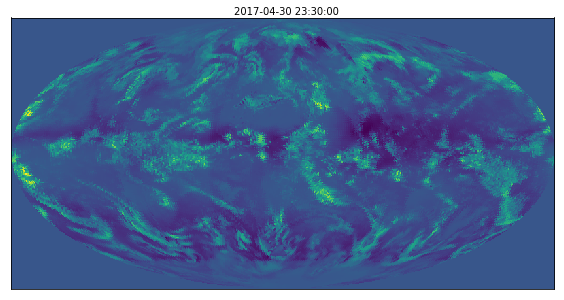

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

im = plt.imshow(plotting_maps[0]-mean_world, interpolation='none')
ttl = ax.text(.41, 1.02, date_times[0], transform = ax.transAxes, va='center')
ax.set_xticks([])
ax.set_yticks([])

def init():
    ttl.set_text(date_times[0])    
    im.set_data(plotting_maps[0]-mean_world)
    return ttl, im

def animate(i):
    ttl.set_text(date_times[i])
    im.set_array(plotting_maps[i]-mean_world)
    return [im]

In [20]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=50, metadata=dict(artist='Tom Charnock'), bitrate=None)

In [21]:
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=maps.shape[0], blit=True)
ani.save('map_cloud_only.mp4', writer=writer)

In [5]:
%%HTML
<video width="100%"" height="auto" controls>
  <source src="map.mp4" type="video/mp4">
</video>

In [6]:
%%HTML
<video width="100%"" height="auto" controls>
  <source src="map_cloud_only.mp4" type="video/mp4">
</video>

In [2]:
from S2CNN import S2CNN
import tensorflow as tf

In [4]:
tf.reset_default_graph()

sph_conv_1 = S2CNN(47, 64, 64, 7, 0, 3, 32, 0, "w_1")
sph_conv_2 = S2CNN(47, 64, 64, 7, 0, 32, 32, 0, "w_2", input_sphere=tf.cast(sph_conv_1.T, dtype=tf.complex64))
sph_conv_3 = S2CNN(47, 64, 64, 7, 0, 32, 1, 0, "w_3", input_sphere=tf.cast(sph_conv_2.T, dtype=tf.complex64))

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
convolved_map = sess.run(sph_conv_3.T, feed_dict = {sph_conv_1.s: [np.load("cloud_cover/maps.npy")[0]], sph_conv_1.indices: sph_conv_1.weight_indices})[0]

In [ ]:
hp.mollview(convolved_map[:, 0])